<a href="https://colab.research.google.com/github/sahinozan/Titanic/blob/master/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 1. Preparation


### 1.1 Importing Libraries


In [465]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict, cross_validate, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
import warnings

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")
np.set_printoptions(precision=5)

#### Optional Style Settings


In [466]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
sns.set(rc={"figure.dpi": 200, 'savefig.dpi': 200})
sns.set_context('notebook')
sns.set_style("ticks")

### 1.2 Load Dataset


In [467]:
df_train = pd.read_csv('https://raw.githubusercontent.com/sahinozan/Titanic/master/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/sahinozan/Titanic/master/test.csv')

In [468]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [469]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 1.3 Checking Null Values


In [470]:
pd.DataFrame(data=[df_train.isna().sum(), df_test.isna().sum()], index=['Train', 'Test']).T

,Train,Test
PassengerId,0.0,0.0
Survived,0.0,NaN
Pclass,0.0,0.0
Name,0.0,0.0
Sex,0.0,0.0
Age,177.0,86.0
SibSp,0.0,0.0
Parch,0.0,0.0
Ticket,0.0,0.0
Fare,0.0,1.0


**Age** and **Cabin** features have too many null values. **Embarked** feature has 2 null values in Train data. **Fare** feature has a single null value in Test data.


### 1.4 Checking Duplicate Values


In [471]:
print(f'Number of duplicate values in train data: {df_train.duplicated().sum()}')
print(f'Number of duplicate values in test data: {df_test.duplicated().sum()}')

Number of duplicate values in train data: 0
Number of duplicate values in test data: 0


There are no duplicate values in train and test data.


### 1.5 Checking Dataset Features


In [472]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [473]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We have 12 features in the dataset.

- **PassengerId**: Identification number of the passenger
- **Survival**: Whether a passenger survived or not (0 or 1)
- **Pclass**: The socio-economic class
  - Upper: 1
  - Middle 2
  - Lower: 3
- **Name**: Name of the passenger
- **Sex**: Gender of the passenger (Male or Female)
- **Age**: Age of the passenger in years
- **SibSp**: Number of siblings / spouses aboard
- **Parch**: Number of parents / children aboard
- **Ticket**: Ticket Number
- **Fare**: Passenger Fare
- **Cabin**: Cabin Number
- **Embarked**: Port of Embarkation
  - C: Cherbourg
  - Q: Queenstown
  - S: Southampton


Numerical:

- **Age**, **SibSp**, **Parch**, and **Fare**

Categorical:

- **Survival**, **Pclass**, **Sex**, **Ticket**, **Cabin**, and **Embarked**, **Name**, **PassengerId**


**Name**, **Sex**, **Ticket**, **Cabin**, and **Embarked** features are `object` type. **Sex** and **Embarked** features consists of only a few values therefore, we will convert them into the `category` type to increase efficiency.

> **Name**, **Ticket**, and **Cabin** features will not be in the training set so, we will not convert them into `category` type.


In [474]:
df_train[['Sex', 'Embarked']] = df_train[['Sex', 'Embarked']].astype('category')

In [475]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
dtypes: category(2), float64(2), int64(5), object(3)
memory usage: 71.7+ KB


## 2. Exploratory Data Analysis


### 2.1 Univariate Analysis


We will analyze and visualize features separately to understand the data in depth. We will use bar plot and pie chart for `categorical` features. We will use histogram and box plot for `numerical` features.


In [476]:
def bar_plot_annotate(axes, column):
    for _i in range(len(df_train[column].unique())):
        _x = axes.patches[_i].get_x() + g.patches[_i].get_width() / 2
        _y = axes.patches[_i].get_height() / 2
        g.annotate(text=df_train.groupby(column).agg({'Ticket': 'count'}).loc[df_train[column].unique()[_i], 'Ticket'], xy=(_x, _y), ha='center')

#### 2.1.1 Analysis of Survived


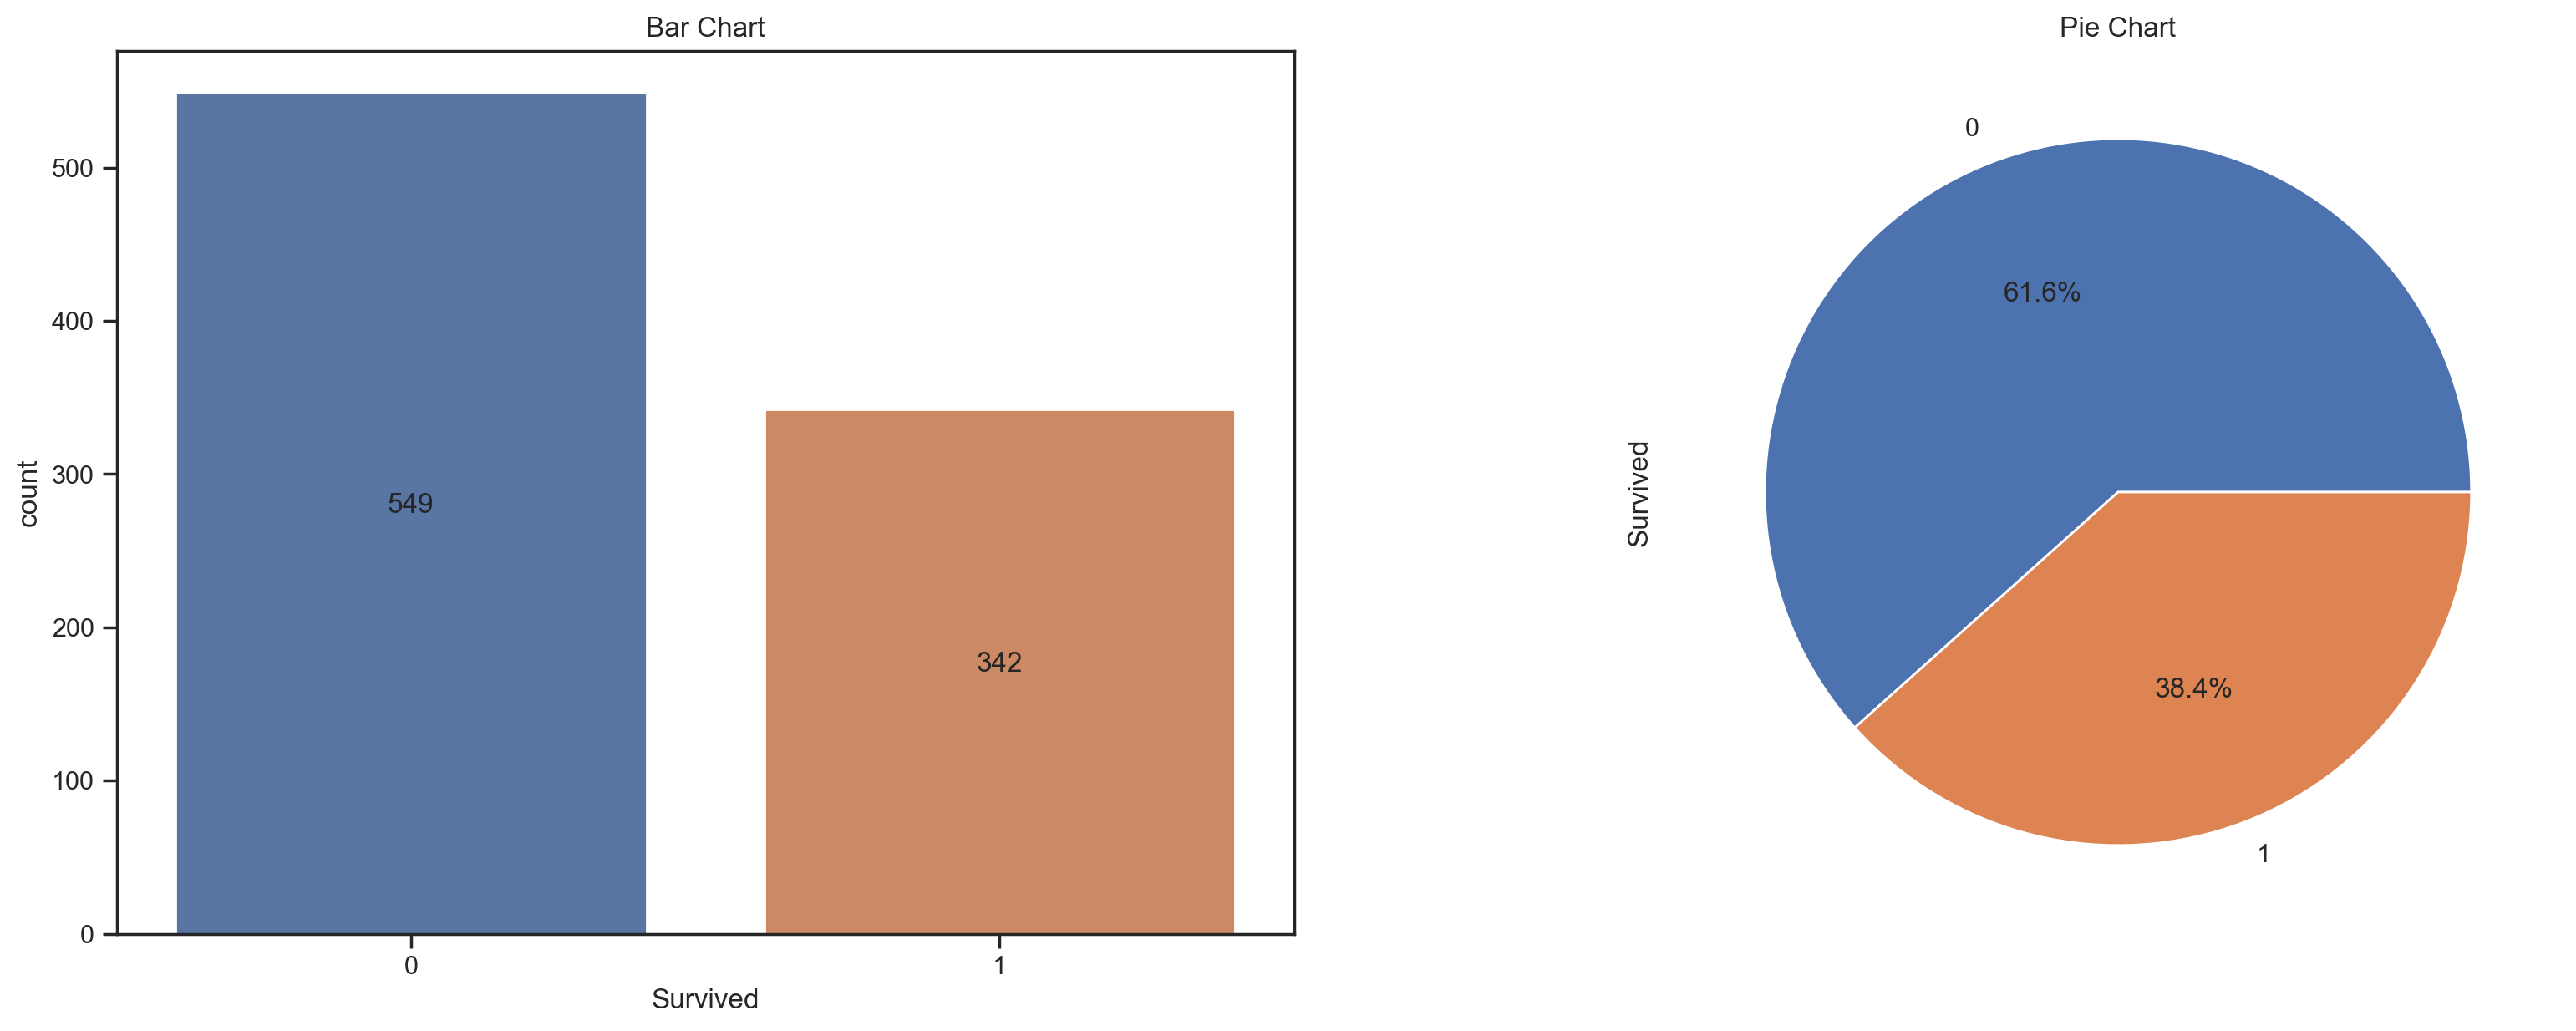

In [477]:
_, ax = plt.subplots(1, 2, figsize=(20, 7))
g = sns.countplot(data=df_train, x='Survived', ax=ax[0])
ax[0].set_title('Bar Chart')

df_train['Survived'].value_counts().plot(kind='pie', autopct="%1.1f%%", ax=ax[1])
ax[1].set_title('Pie Chart')

bar_plot_annotate(g, 'Survived')
plt.show()

We will analyze to find out what caused **38.4%** of the passengers to survive.

- **61.6%** of the passengers did **not** survive.
- Only **38.4%** of the passengers did survive.


#### 2.1.2 Analysis of Sex


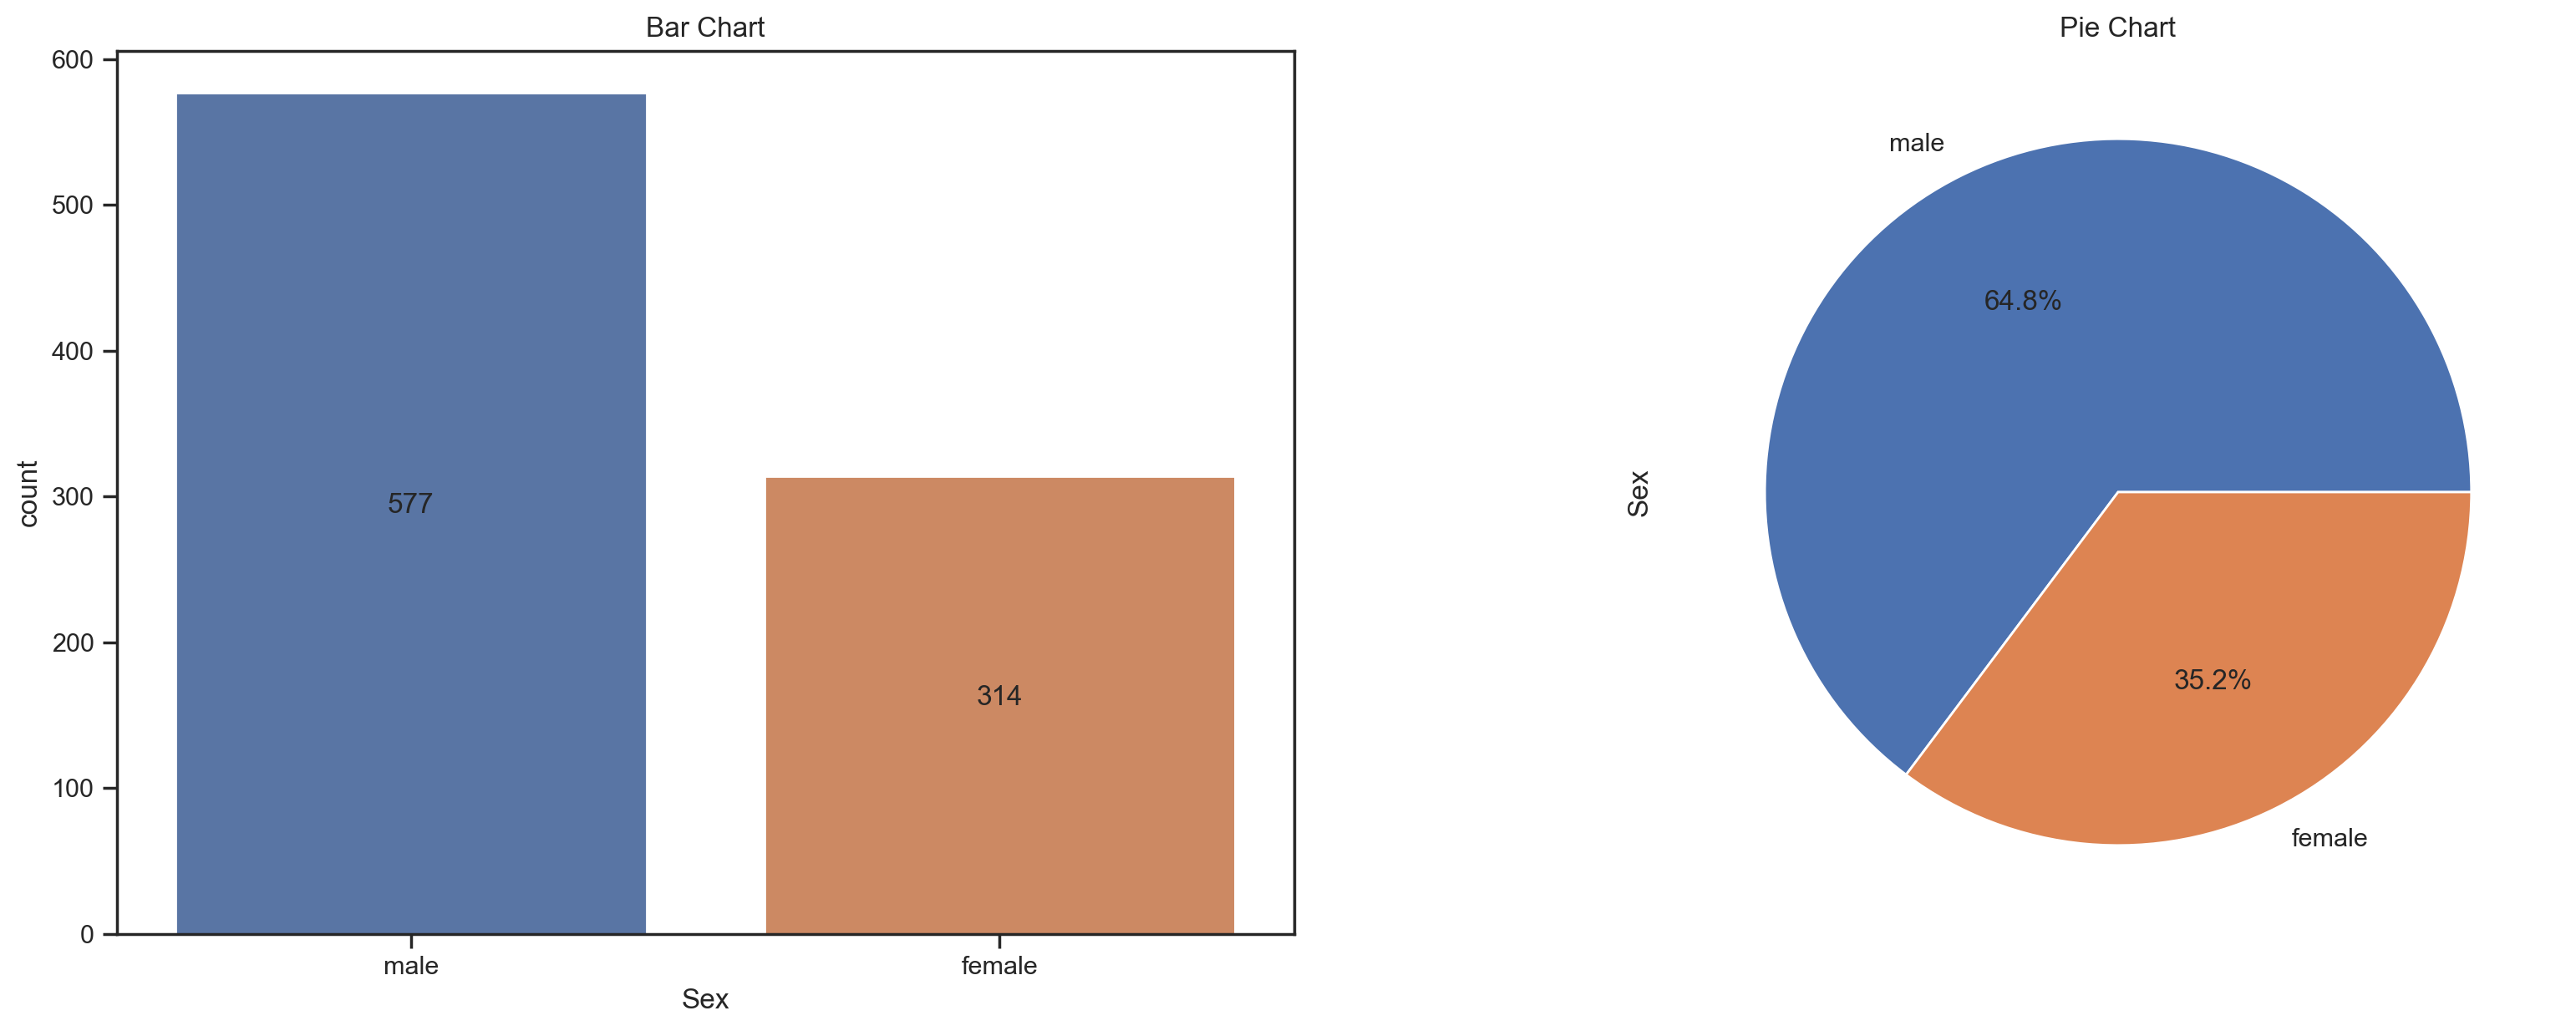

In [478]:
_, ax = plt.subplots(1, 2, figsize=(20, 7))
g = sns.countplot(data=df_train, x='Sex', order=['male', 'female'], ax=ax[0])
ax[0].set_title('Bar Chart')

df_train['Sex'].value_counts().plot(kind='pie', autopct="%1.1f%%", ax=ax[1])
ax[1].set_title('Pie Chart')

bar_plot_annotate(g, 'Sex')
plt.show()

- **64.8%** of the passengers are **Male**.
- Only **35.2%** of the passengers are **Female**.


#### 2.1.3 Analysis of Age


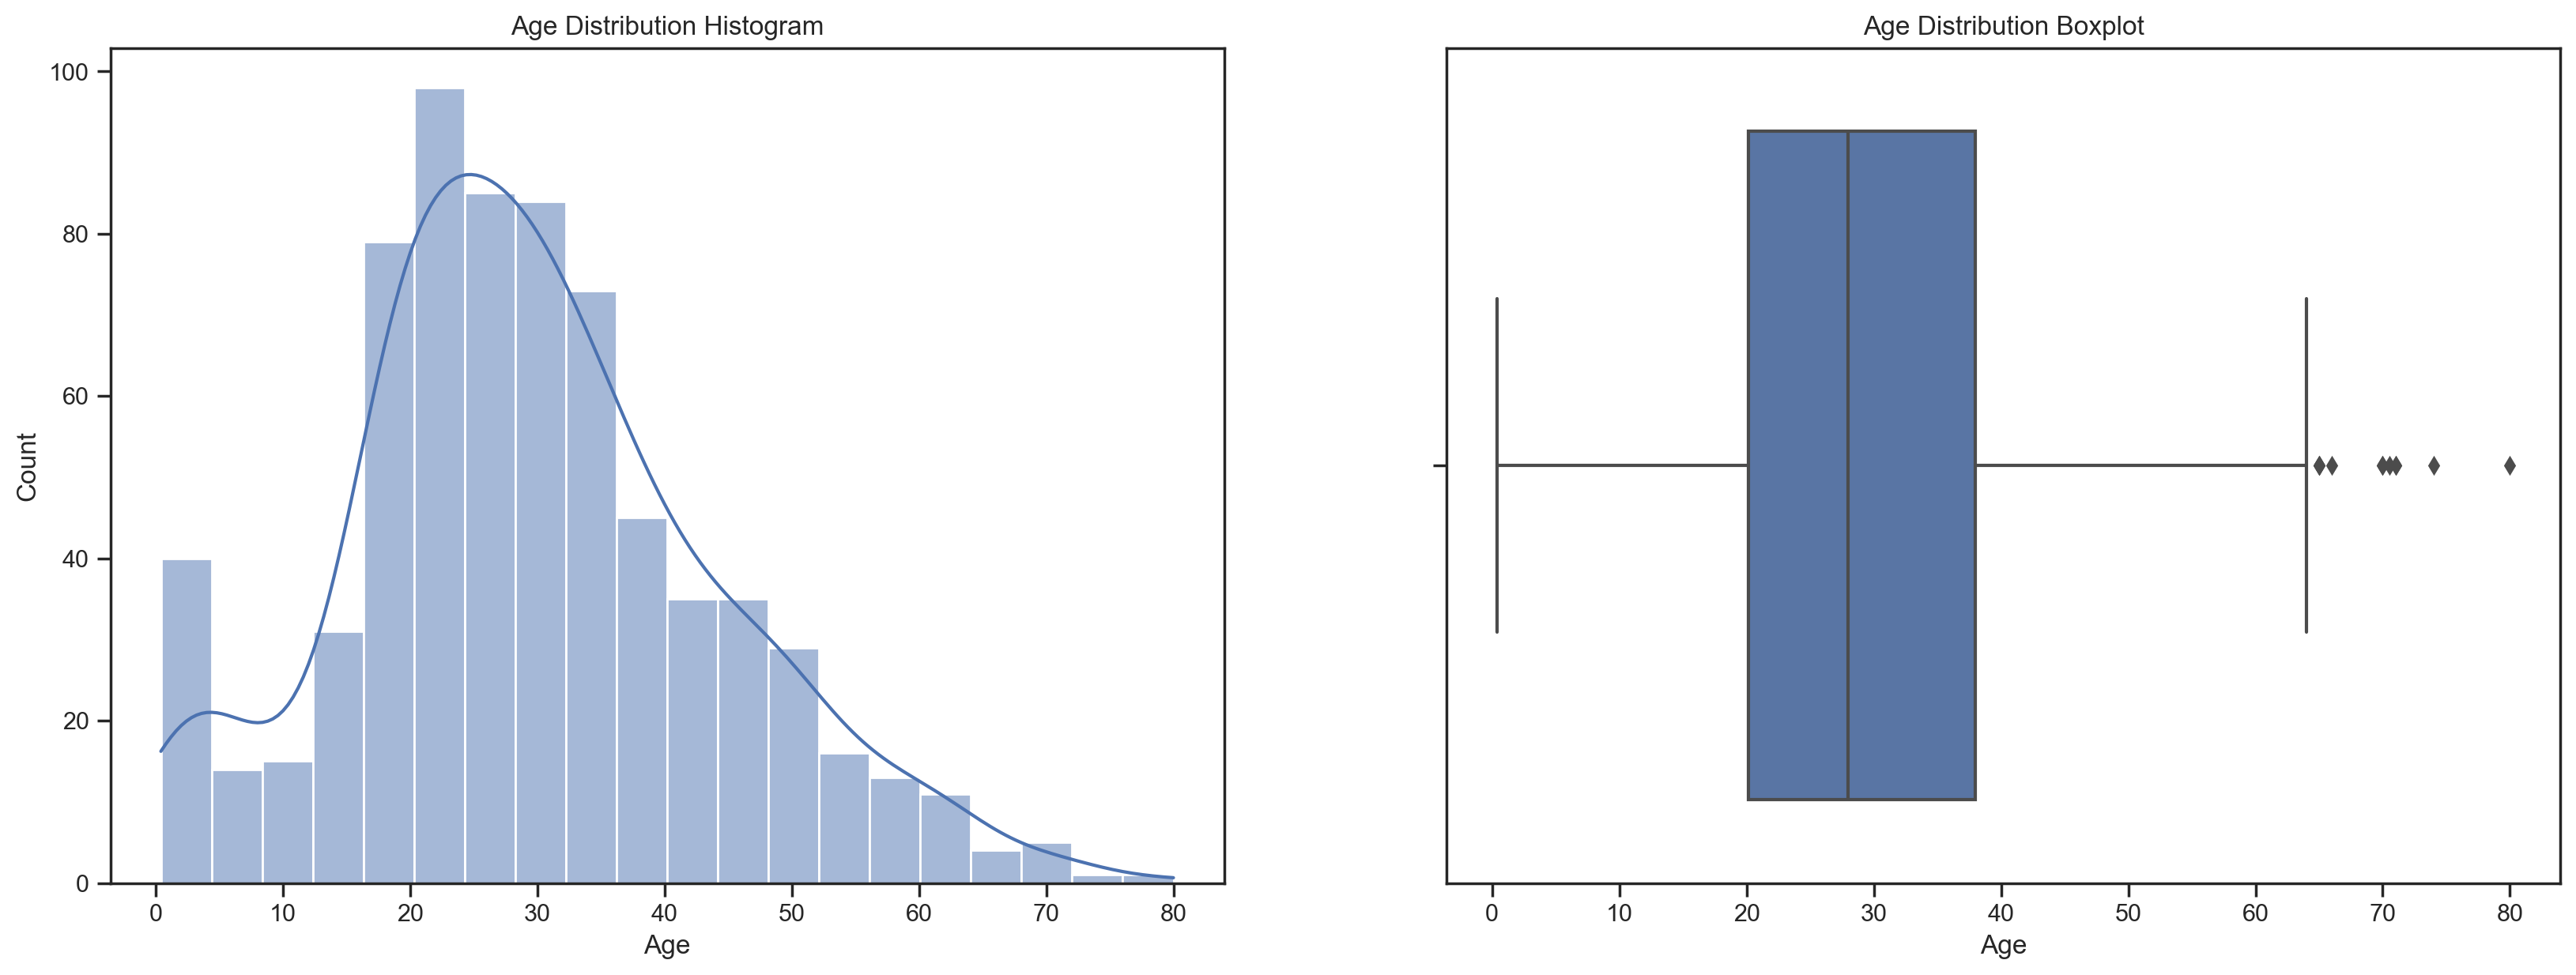

In [479]:
_, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.histplot(data=df_train, x='Age', kde=True, ax=ax[0])
ax[0].set_title('Age Distribution Histogram')

sns.boxplot(data=df_train, x='Age', ax=ax[1])
ax[1].set_title('Age Distribution Boxplot')
plt.show()

In [480]:
print(f'Average Age: {df_train["Age"].mean()}')
print(f'Lowest Age: {df_train["Age"].min()}')
print(f'Highest Age: {df_train["Age"].max()}')

Average Age: 29.69911764705882
Lowest Age: 0.42
Highest Age: 80.0


In [481]:
number_of_people = max(dict(df_train["Age"].value_counts()).values())
most_frequent_age = [key for key, value in dict(df_train["Age"].value_counts()).items() if value == number_of_people]
print(f'Most frequent age is {most_frequent_age[0]} with {number_of_people} passengers.')

Most frequent age is 24.0 with 30 passengers.


Age of the passengers varies from **0.42** to **80** years with an average of **29.7**.


#### 2.1.4 Analysis of Fare


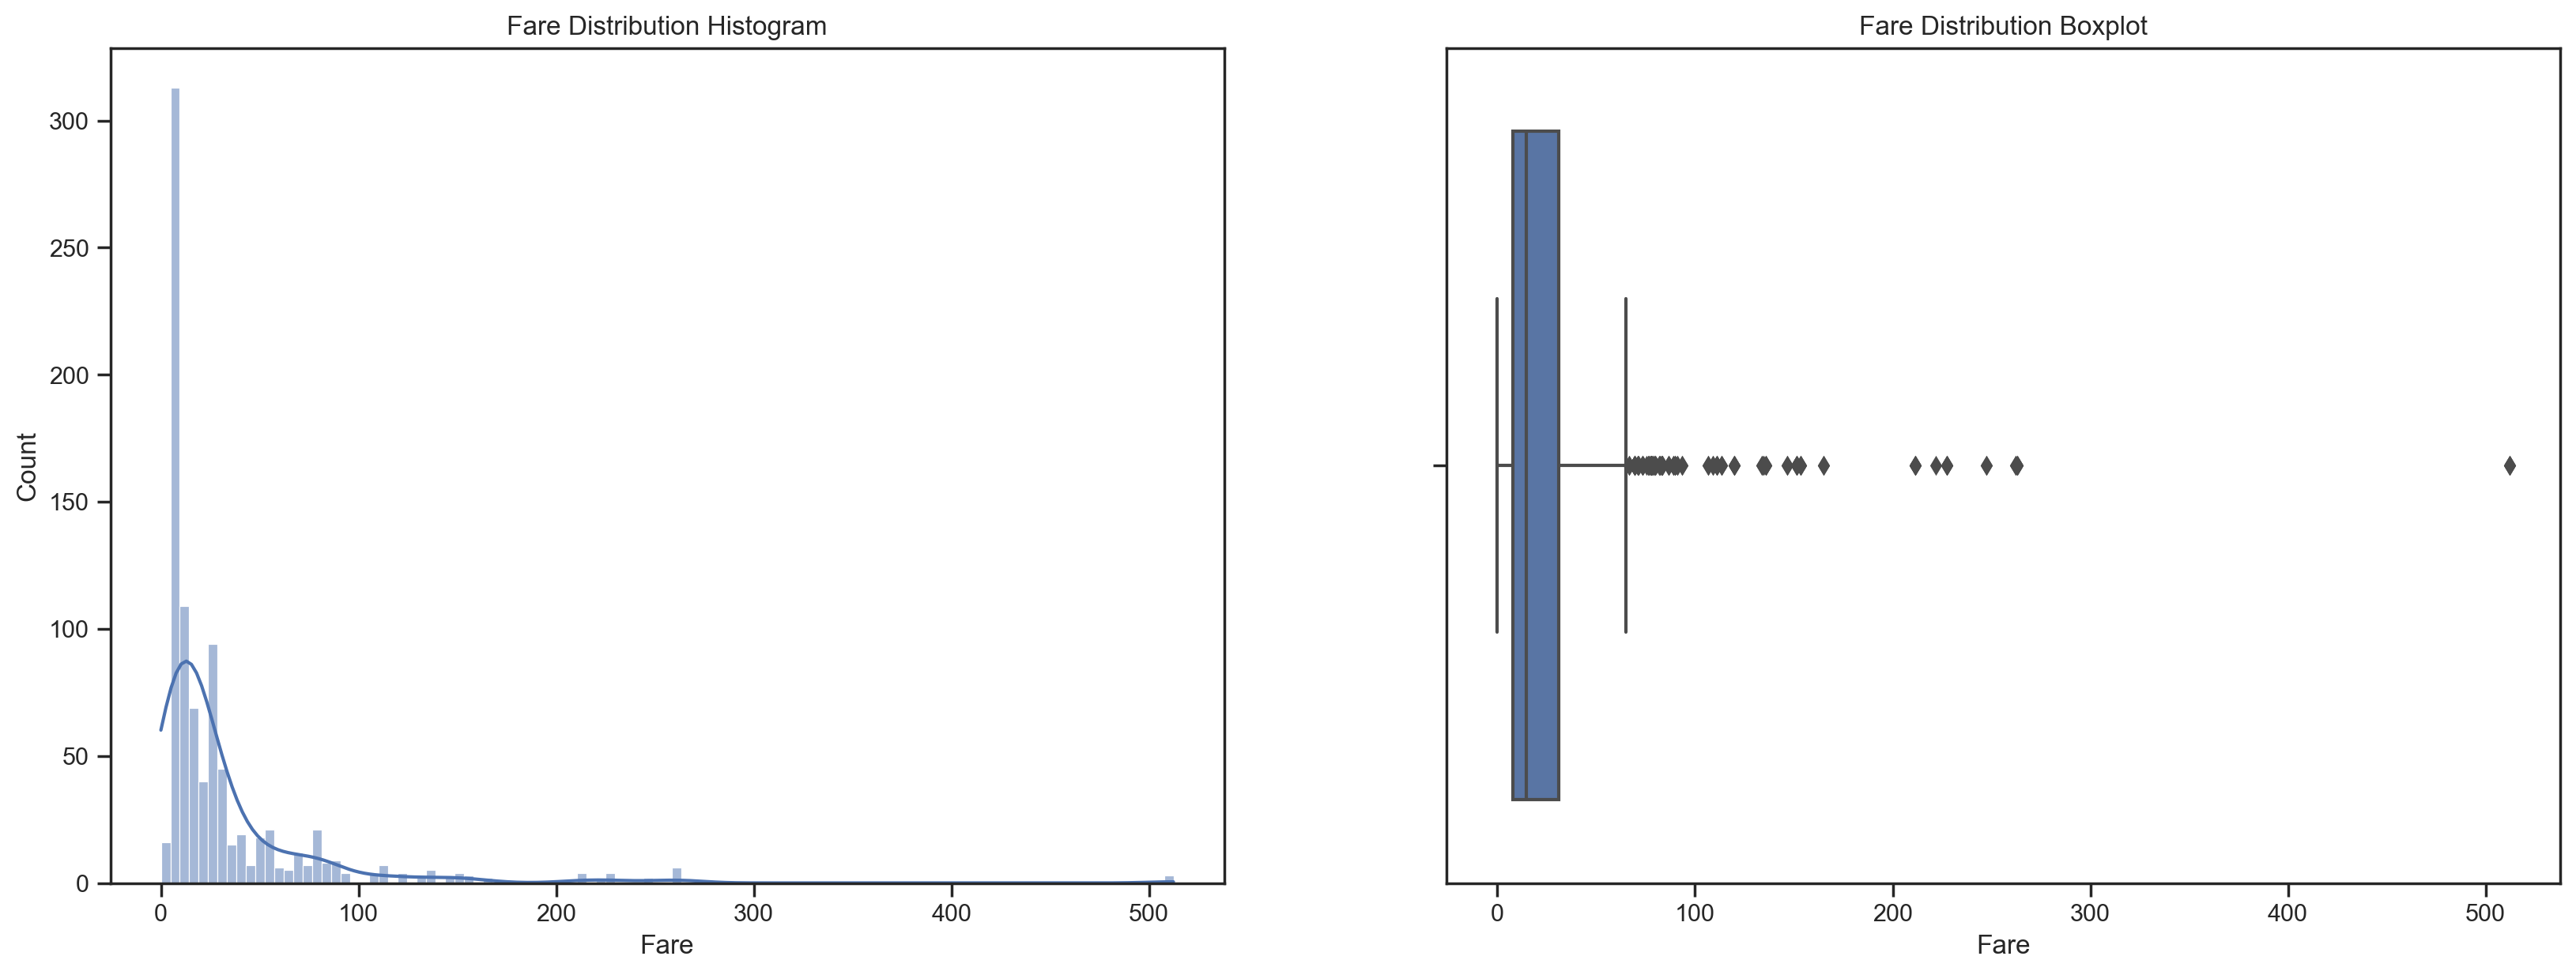

In [482]:
_, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.histplot(data=df_train, x='Fare', kde=True, ax=ax[0])
ax[0].set_title('Fare Distribution Histogram')

sns.boxplot(data=df_train, x='Fare', ax=ax[1])
ax[1].set_title('Fare Distribution Boxplot')
plt.show()

In [483]:
print(f'Average Fare: ${df_train["Fare"].mean():.2f}')
print(f'Lowest Fare: ${df_train["Fare"].min()}')
print(f'Highest Fare: ${df_train["Fare"].max():.2f}')

Average Fare: $32.20
Lowest Fare: $0.0
Highest Fare: $512.33


In [484]:
print('Number of passengers who paid $0.0: ', df_train[df_train["Fare"] == df_train["Fare"].min()].shape[0])
print('Number of passengers who paid $512.33: ', df_train[df_train["Fare"] == df_train["Fare"].max()].shape[0])

Number of passengers who paid $0.0:  15
Number of passengers who paid $512.33:  3


In [485]:
number_of_people = max(dict(df_train["Fare"].value_counts()).values())
most_frequent_fare = [key for key, value in dict(df_train["Fare"].value_counts()).items() if value == number_of_people]
print(f'Most frequent fare is ${most_frequent_fare[0]} which is paid by {number_of_people} passengers.')

Most frequent fare is $8.05 which is paid by 43 passengers.


- There are passengers who did **not** pay for the cruise.
- Only 3 passengers paid **512.33** dollars.
- 15 passengers paid **0.0** dollars.
- Average fare is **32.2** dollars.


#### 2.1.5 Analysis of Pclass


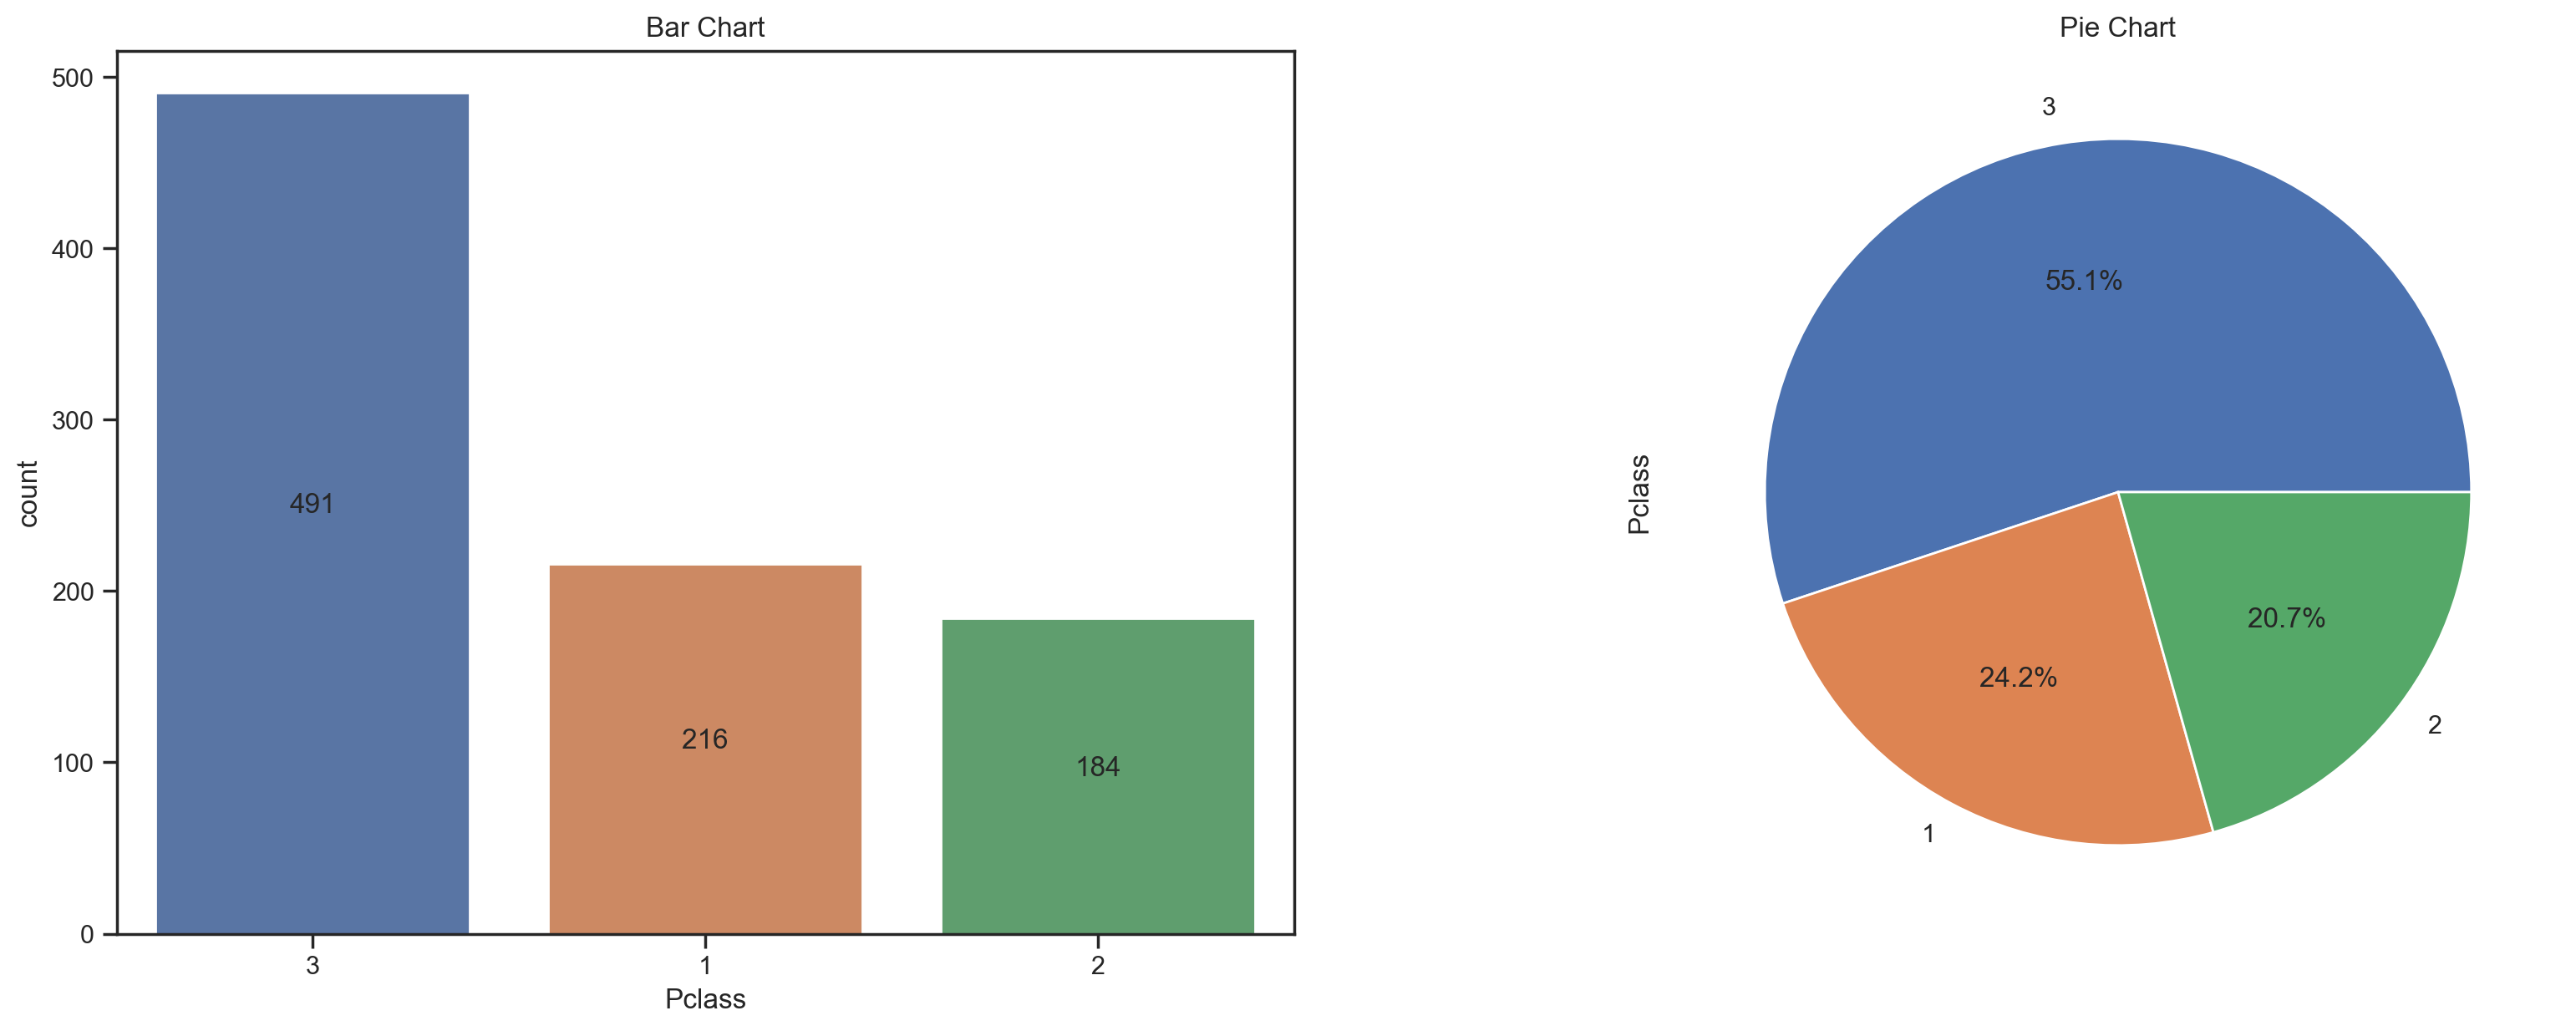

In [486]:
_, ax = plt.subplots(1, 2, figsize=(20, 7))
g = sns.countplot(data=df_train, x='Pclass', order=[3, 1, 2], ax=ax[0])
ax[0].set_title('Bar Chart')

df_train['Pclass'].value_counts().plot(kind='pie', autopct="%1.1f%%", ax=ax[1])
ax[1].set_title('Pie Chart')

bar_plot_annotate(g, 'Pclass')
plt.show()

**55.1%** of the passengers have 3rd class ticket. Meanwhile, the number of passengers who have 1st and 2nd class ticket are quite close with **24.2%** and **20.7%** respectively.


#### 2.1.6 Analysis of SibSp and Parch


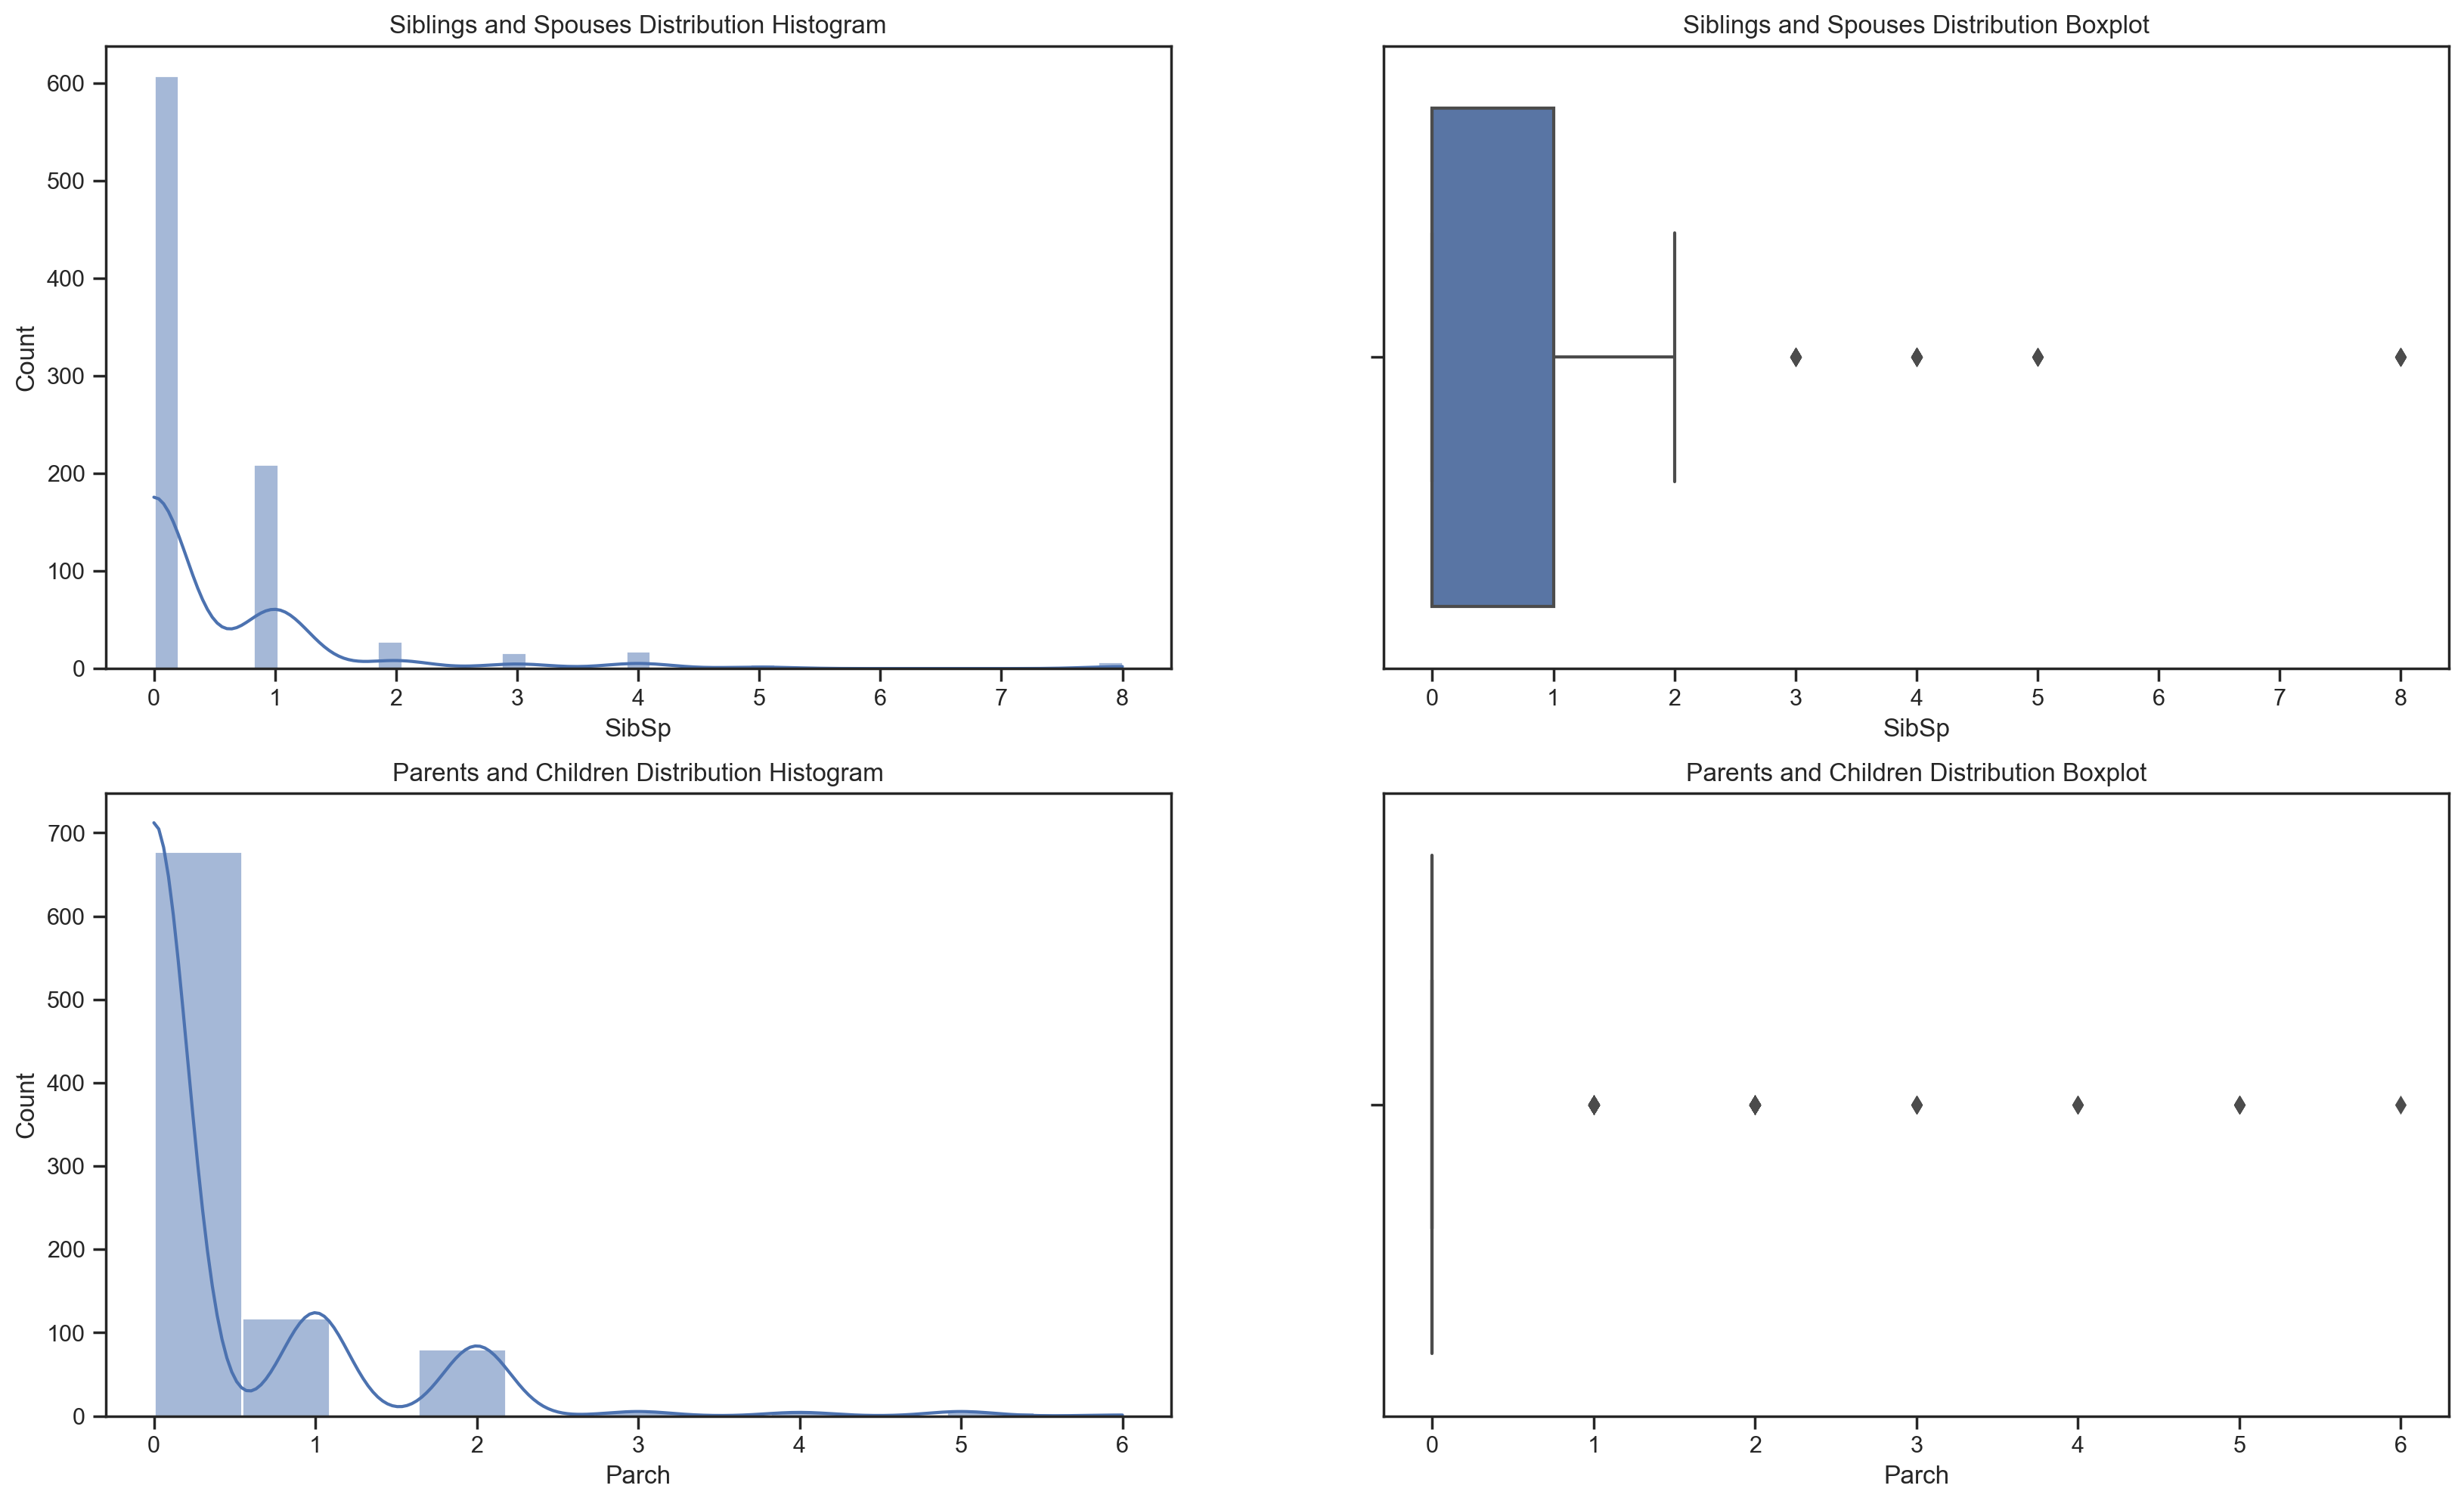

In [487]:
_, ax = plt.subplots(2, 2, figsize=(20, 12))
sns.histplot(data=df_train, x='SibSp', kde=True, ax=ax[0, 0])
ax[0, 0].set_title('Siblings and Spouses Distribution Histogram')

sns.boxplot(data=df_train, x='SibSp', ax=ax[0, 1])
ax[0, 1].set_title('Siblings and Spouses Distribution Boxplot')

sns.histplot(data=df_train, x='Parch', kde=True, ax=ax[1, 0])
ax[1, 0].set_title('Parents and Children Distribution Histogram')

sns.boxplot(data=df_train, x='Parch', ax=ax[1, 1])
ax[1, 1].set_title('Parents and Children Distribution Boxplot')

plt.show()

- Over **600** passengers traveling alone.
- There are also over **100** passengers traveling with 1 person.


#### 2.1.7 Analysis of Embarked


IndexError: list index out of range

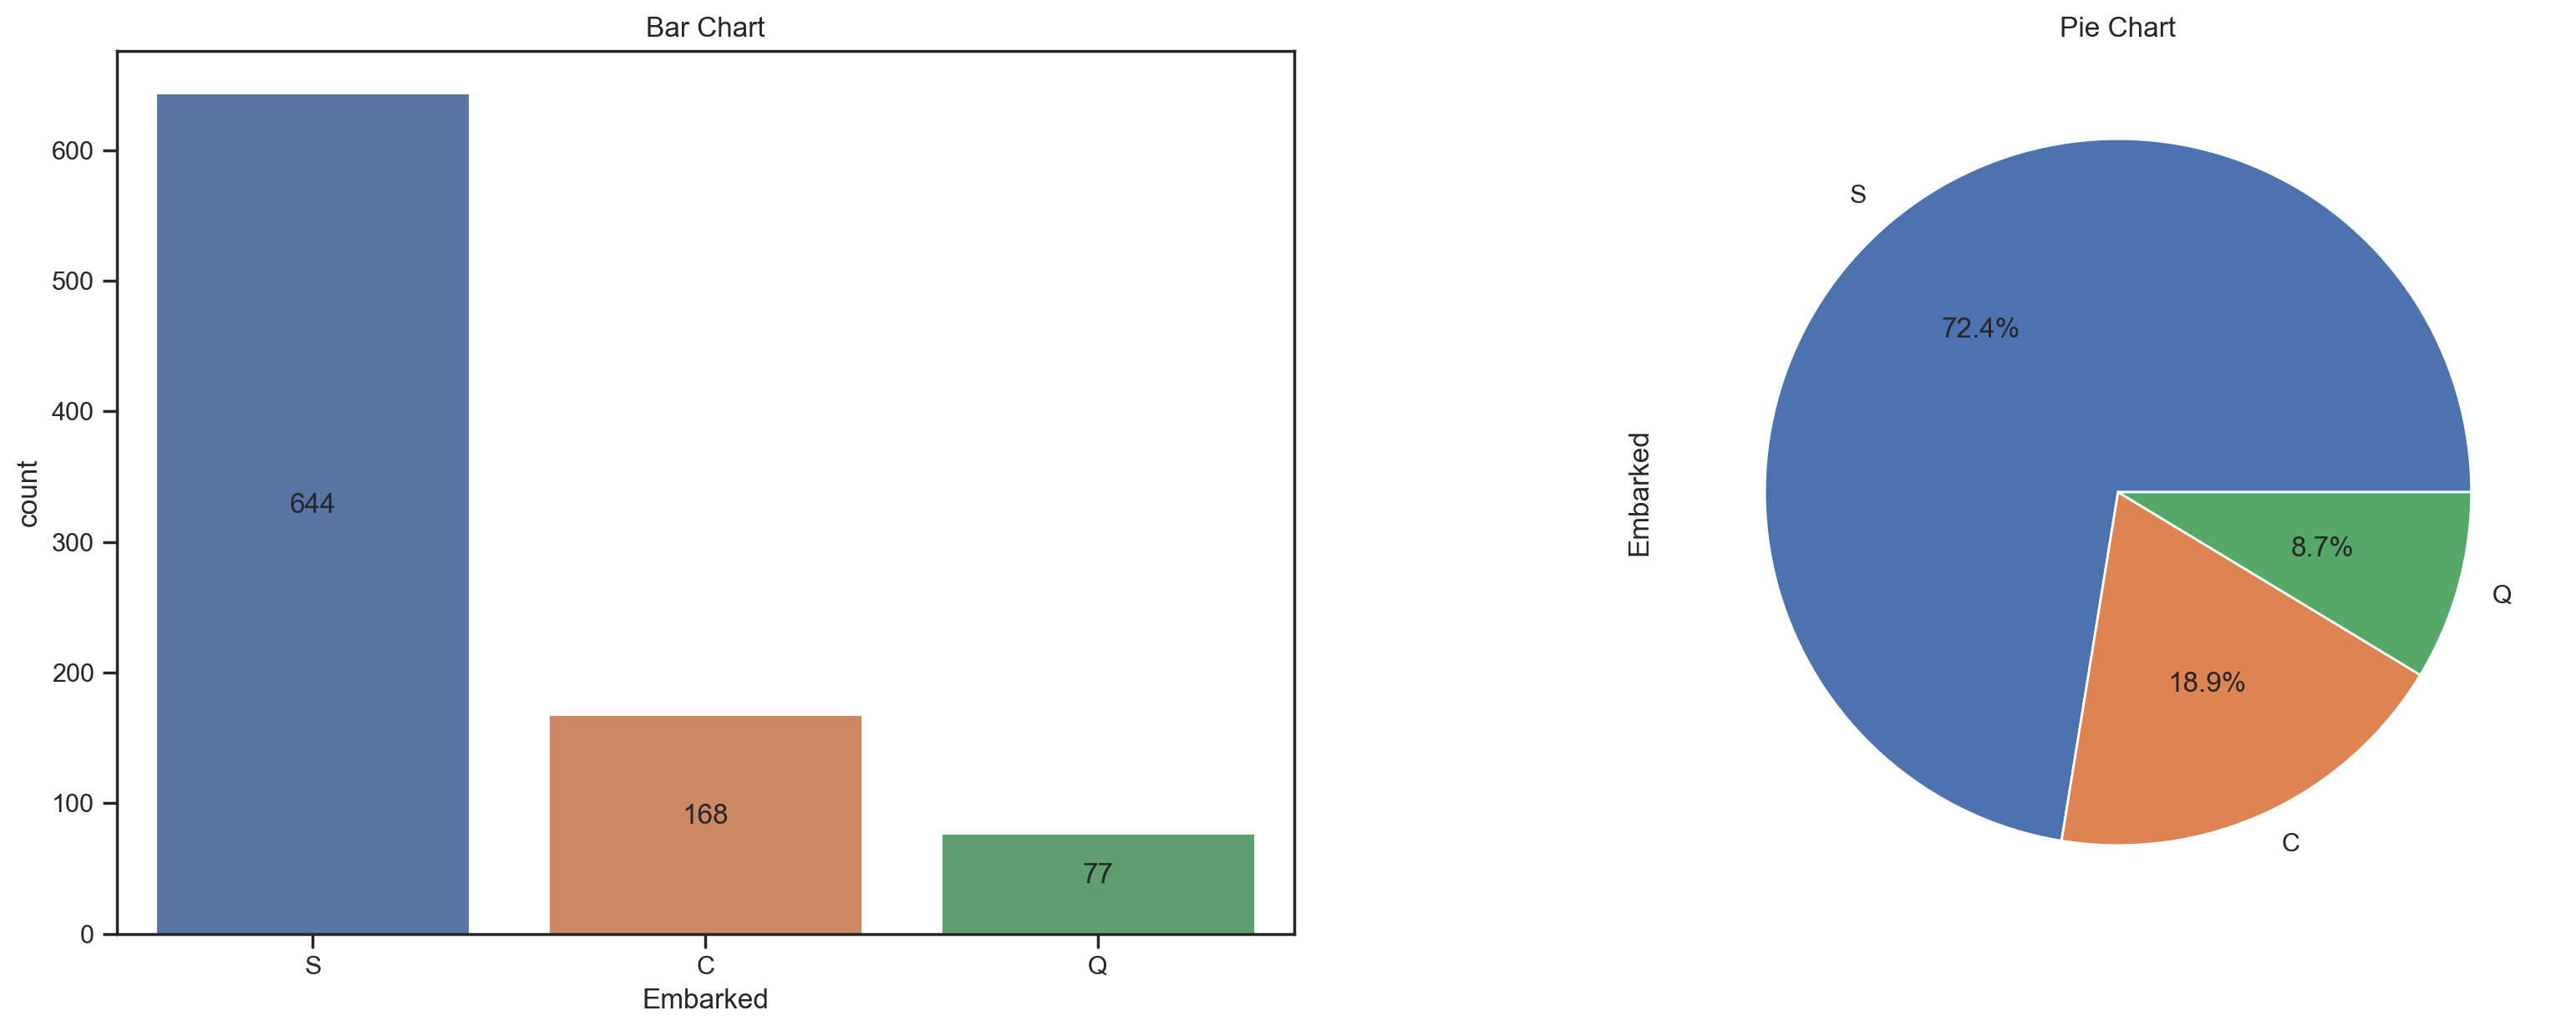

In [488]:
_, ax = plt.subplots(1, 2, figsize=(20, 7))
g = sns.countplot(data=df_train, x='Embarked', order=['S', 'C', 'Q'], ax=ax[0])
ax[0].set_title('Bar Chart')

df_train['Embarked'].value_counts().plot(kind='pie', autopct="%1.1f%%", ax=ax[1])
ax[1].set_title('Pie Chart')

bar_plot_annotate(g, 'Embarked')
plt.show()

Most of the passengers, approximately **72.4%** boarded the Titanic from Southampton.


### 2.2 Multivariate Analysis


#### 2.2.1 Analysis of Survived and Age


In [ ]:
plt.figure(figsize=(20, 7))
sns.histplot(data=df_train, x='Age', hue='Survived', multiple='stack', kde=True)
plt.show()

In [ ]:
number_of_survival_under_10 = df_train[(df_train['Age'] <= 10) & (df_train['Survived'] == 1)].shape[0]
number_of_survival_over_65 = df_train[(df_train['Age'] >= 65) & (df_train['Survived'] == 1)].shape[0]

In [ ]:
print(f'Number of people survived in 0-10 age range: {number_of_survival_under_10}')
print(f'Number of people survived in 65+ age range: {number_of_survival_over_65}')

- The **0-10** age range has a higher rate of survival. Maybe kids had a higher priority for the lifeboats.
- The **65+** age range has an extremely low rate of survival. This outcome may have happened because elders have a relatively low physical capacity to survive.


#### 2.2.2 Analysis of Survived and Sex


In [ ]:
plt.figure(figsize=(20, 7))
sns.histplot(data=df_train, x='Sex', hue='Survived', multiple='stack')
plt.show()

In [ ]:
for i in ['female', 'male']:
    survived = df_train[(df_train['Sex'] == i) & (df_train['Survived'] == 1)].shape[0]
    total = df_train[df_train['Sex'] == i].shape[0]
    print(f'{survived / total * 100 :.2f}% of the {i} passengers survived.')

- Most of the survivors are **female**.
- Huge amount of female passengers survived.
- Small amount of male passengers survived.


#### 2.2.3 Analysis of Survived and Pclass


In [ ]:
plt.figure(figsize=(20, 7))
ax = sns.histplot(data=df_train, x='Pclass', hue='Survived', multiple='stack', discrete=True)
ax.set_xticks([1, 2, 3])
plt.show()

In [ ]:
for i in range(1, 4):
    survived = df_train[(df_train['Pclass'] == i) & (df_train['Survived'] == 1)].shape[0]
    total = df_train[df_train['Pclass'] == i].shape[0]
    print(f'{survived / total * 100 :.2f}% of the Pclass-{i} passengers survived.')

- Upper-class people survived more compared Middle and Lower class people.
- Maybe Upper-class people had a higher priority in the rescue process.


#### 2.2.4 Analysis of Survived and Embarked


In [ ]:
plt.figure(figsize=(20, 7))
ax = sns.histplot(data=df_train, x='Embarked', hue='Survived', multiple='stack', discrete=True)
plt.show()

In [ ]:
for i, k in {"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"}.items():
    survived = df_train[(df_train['Embarked'] == i) & (df_train['Survived'] == 1)].shape[0]
    total = df_train[df_train['Embarked'] == i].shape[0]
    print(f'{survived / total * 100 :.2f}% of the passengers embarked in {k} survived.')

- Most of the passengers who survived are boarded from **Southampton**. This may be due to the fact that **Southampton** is the most crowded port.
- More than **50%** of the passengers who boarded from **Cherbourg** survived.


#### 2.2.5 Analysis of Survived and SipSb


In [ ]:
plt.figure(figsize=(20, 7))
sns.histplot(data=df_train, x='SibSp', hue='Survived', multiple='stack', kde=True)
plt.show()

#### 2.2.6 Analysis of Survived and Parch


In [ ]:
plt.figure(figsize=(20, 7))
sns.histplot(data=df_train, x='Parch', hue='Survived', multiple='stack', kde=True)
plt.show()

## 3. Feature Engineering


In [ ]:
df_train.columns

In [ ]:
plt.figure(figsize=(20, 7))
sns.heatmap(data=df_train.corr(), annot=True)
plt.show()

When we look at the relations between `Survived` and other features, we observe:

- `PassengerId` has a low negative correlation with `Survived`, approximately **-0.005**.
- `Pclass` has a high negative correlation with `Survived`, approximately **-0.34**.
- `Fare` has a high positive relation with `Survived`, approximately **0.26**.


### 3.1 PassengerId


In [ ]:
df_train['PassengerId']

**PassengerId** column contains **891** unique values for each passenger. Meaning that we can't use this feature because it does not contain any valuable information for us. We are removing this column from the dataset.


In [ ]:
df_train.drop('PassengerId', axis=1, inplace=True)
df_test.drop('PassengerId', axis=1, inplace=True)

### 3.2 Name


In [ ]:
df_train['Name']

Name column contains unique values for each passenger. Meaning that we can't use this feature because it does not contain any valuable information for us. We are removing this column from the dataset.


In [ ]:
df_train.drop(labels='Name', axis=1, inplace=True)
df_test.drop(labels='Name', axis=1, inplace=True)

### 3.3 Ticket


In [ ]:
df_train['Ticket']

**Ticket** column contains **891** unique values for each passenger. These values are not valuable for us. Therefore, we are removing this column from the dataset.


In [ ]:
df_train.drop(labels='Ticket', axis=1, inplace=True)
df_test.drop(labels='Ticket', axis=1, inplace=True)

### 3.4 Cabin


In [ ]:
df_train['Cabin']

In [ ]:
print(f'Missing cabin values in train data: {df_train["Cabin"].isna().sum() / df_train["Cabin"].shape[0] * 100:.2f}%')
print(f'Missing cabin values in test data: {df_test["Cabin"].isna().sum() / df_test["Cabin"].shape[0] * 100:.2f}%')

**Cabin** column contains too many **(77.10%)** missing values. That is why we are removing this from the dataset.


In [ ]:
df_train.drop(labels='Cabin', axis=1, inplace=True)
df_test.drop(labels='Cabin', axis=1, inplace=True)

### 3.5 Age


In [ ]:
df_train['Age']

In [ ]:
print(f'Missing age values in train data: {df_train["Age"].isna().sum() / df_train["Age"].shape[0] * 100:.2f}%')
print(f'Missing age values in test data: {df_test["Age"].isna().sum() / df_test["Age"].shape[0] * 100:.2f}%')

There are missing values in the **Age** column. Amount of missing values are not too much **(19.87%)**. This is why we will try to do data imputation on this feature.


In [ ]:
imputer = SimpleImputer(strategy='median')
imputer = imputer.fit(df_train[['Age']])
df_train['Age'] = imputer.transform(df_train[['Age']])

In [ ]:
imputer = imputer.fit(df_test[['Age']])
df_test['Age'] = imputer.transform(df_test[['Age']])

### 3.6 Fare


In [ ]:
df_train['Fare']

In [ ]:
print(f'Number of missing fare values in train data: {df_train["Fare"].isna().sum()}')
print(f'Number of missing fare values in test data: {df_test["Fare"].isna().sum()}')

There is only a single missing value in test data. This is why we will try to do data imputation on this feature.


In [ ]:
imputer = imputer.fit(df_test[['Fare']])
df_test['Fare'] = imputer.transform(df_test[['Fare']])

### 3.7 Embarked


In [ ]:
df_train['Embarked']

In [ ]:
print(f'Number of missing embarked values in train data: {df_train["Embarked"].isna().sum()}')
print(f'Number of missing embarked values in test data: {df_test["Embarked"].isna().sum()}')

There are only 2 missing values in train data. Similar to previous features, we will do data imputation on this feature.


In [ ]:
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(df_train[['Embarked']])
df_train[['Embarked']] = imputer.transform(df_train[['Embarked']])

We will also use **OneHotEncoder** to extract separate features from this column. We will create **C**, **Q**, and **S** features which will represent **Cherbourg**, **Queenstown**, and **Southampton**.


In [ ]:
encoder = OneHotEncoder(sparse=False)
encoder = encoder.fit(df_train[['Embarked']])
df_train[['C', 'Q', 'S']] = encoder.transform(df_train[['Embarked']])

In [ ]:
encoder = encoder.fit(df_test[['Embarked']])
df_test[['C', 'Q', 'S']] = encoder.transform(df_test[['Embarked']])

We successfully separated the **Embarked** column into **C**, **Q**, and **S** columns. Now we can remove the **Embarked** column itself because we don't need it anymore.


In [ ]:
df_train.drop(labels='Embarked', axis=1, inplace=True)
df_test.drop(labels='Embarked', axis=1, inplace=True)

### 3.8 Sex


In [ ]:
df_train['Sex']

In [ ]:
print(f'Number of missing sex values in train data: {df_train["Sex"].isna().sum()}')
print(f'Number of missing sex values in test data: {df_test["Sex"].isna().sum()}')

- We don't have **any** missing values in **Sex** column. Therefore, we can use this feature. We convert this category to a vector.
- Similar to **Embarked**, we will again use **OneHotEncoder** to extract separate features from this column. We will create **Female** and **Male** features.


In [ ]:
encoder = OneHotEncoder(sparse=False)
encoder = encoder.fit(df_train[['Sex']])
df_train[['Female', 'Male']] = encoder.transform(df_train[['Sex']])

In [ ]:
encoder = encoder.fit(df_test[['Sex']])
df_test[['Female', 'Male']] = encoder.transform(df_test[['Sex']])

In [ ]:
df_train.head()

We successfully separated the **Sex** column into **Female** and **Male** columns. Now we can remove the **Sex** column itself because we don't need it anymore.


In [ ]:
df_train.drop(labels='Sex', axis=1, inplace=True)
df_test.drop(labels='Sex', axis=1, inplace=True)

### 3.9 Parch and SibSp


We will combine **Parch** and **SibSp** columns into a single feature called **FamilySize**.


In [ ]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch']
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch']
df_train.drop(labels=['SibSp', 'Parch'], axis=1, inplace=True)
df_test.drop(labels=['SibSp', 'Parch'], axis=1, inplace=True)

In [ ]:
df_train

In [ ]:
df_test

In [ ]:
X_train = df_train.drop(labels='Survived', axis=1)
y_train = df_train['Survived'].copy()
X_test = df_test.copy()

## 4. Model Building


We are done with the data preparation. Now, we are going to build our Machine Learning model.
We are going to use the models below:

- Logistic Regression
- K-Nearest Neighbor (KNN)
- Decision Tree
- Random Forest
- Support Vector Machine


### 4.1 Model Comparison


In [ ]:
estimators = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbor': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}

We will use `cross-validation` to compare our models.


In [ ]:
cv_scores = pd.DataFrame(columns=["Estimator", "F1-Score", "Accuracy", "Overall"])


def compare_models(estimator=estimators, cv=10):
    global cv_scores
    for name, est in estimator.items():
        cv_pred = cross_val_predict(estimator=est, X=X_train, y=y_train, cv=cv)
        cv_score = cross_validate(estimator=est, X=X_train, y=y_train, cv=cv, scoring=(['f1', 'accuracy']))
        cv_scores = cv_scores.append({
            "Estimator": name,
            "F1-Score": cv_score["test_f1"].mean(),
            "Accuracy": cv_score["test_accuracy"].mean(),
            "Overall": (cv_score["test_f1"].mean() + cv_score["test_accuracy"].mean()) / 2
        }, ignore_index=True)
        print(f'\nClassification Report for {name}')
        print(classification_report(y_true=y_train, y_pred=cv_pred))

In [ ]:
compare_models()

We will look at the **F1-Score** and **Accuracy** to decide which model performs better without tuning.


In [ ]:
cv_scores.sort_values('Overall', ascending=False).reindex(
    columns=['Estimator', 'F1-Score', 'Accuracy', 'Overall']).set_index('Estimator')

We can see that **Random Forest** performs best out of all. That's why we will continue with the **RandomForestClassifier**.


### 4.2 Hyperparameter Tuning


We will use **Randomized Searching** to find the best hyperparameter values for the **RandomForestClassifier**.


In [ ]:
n_estimators = np.linspace(50, 300, int((300 - 50) / 20), dtype=int)
max_depth = [1, 5, 10, 50, 100, 200, 300]
min_samples_split = [2, 4, 6]
max_features = ['sqrt', 'log2']
bootstrap = [True, False]

distributions = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'max_features': max_features,
    'bootstrap': bootstrap
}

In [ ]:
rfc = RandomForestClassifier()
random_search_cv = RandomizedSearchCV(
    rfc,
    param_distributions=distributions,
    n_iter=30,
    cv=10,
    n_jobs=4
)

search = random_search_cv.fit(X_train, y_train)